In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

In [18]:
# n = torch.nn.Sequential(
#     torch.nn.Linear(5, 10),
#     torch.nn.ReLU(),
#     torch.nn.Linear(10, 2)
# )

# print(n(torch.rand(5)).shape)
# print(n(torch.rand(2,3,5)).shape)
# print(n(torch.rand(4,4,2,3,5)).shape)

torch.Size([2])
torch.Size([2, 3, 2])
torch.Size([4, 4, 2, 3, 2])


In [2]:
# M = 100 * torch.eye(100) + 10 * torch.rand(100,100)
# M_half = torch.cholesky(M)
# M_inv = torch.inverse(M)
# M_half_inv = torch.inverse(M_half)
# x = torch.randn(1, 100)
# y = x @ M_inv
# y2 = rec_model.chol_inv(M_half, x, left=False)
# print(y - y2)



In [3]:
# v = torch.randn(4, 2, 10)
# Y = torch.randint(0, 10, (4, 5, 10)).float()
# # print(v, Y)
# lik = Poisson_noise()
# model = LDS(v, Y, lik, x_dim=12)
# rec_model = RecognitionModel(model)
# rec_model.get_x_tilde(Y).shape

In [2]:
torch.manual_seed(1)
np.random.seed(1)
v = torch.randn(4, 2, 10)
# Y = torch.randn(4, 5, 10)
Y = torch.randint(0, 10, (4, 50, 10)).float()
# print(v, Y)
lik = Poisson_noise()
model = LDS(v, Y, lik)
# model.joint_LL(3)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 101}
model.train_supervised_model(model.training_params(**train_params))

step 0 LL -1.7402119563176082
step 1 LL -1.6499542236328124
step 2 LL -1.5969603318434495
step 3 LL -1.552973116361178
step 4 LL -1.5193072979266826
step 5 LL -1.4861602783203125
step 6 LL -1.4593998835637019
step 7 LL -1.4312338022085336
step 8 LL -1.4112837571364183
step 9 LL -1.3907404972956732
step 10 LL -1.3689348660982572
step 11 LL -1.3551323523888221
step 12 LL -1.335882333608774
step 13 LL -1.3209342369666466
step 14 LL -1.3067967341496394
step 15 LL -1.2865336491511419
step 16 LL -1.2672025240384615
step 17 LL -1.2485431377704328
step 18 LL -1.244240980881911
step 19 LL -1.2184260441706731
step 20 LL -1.1876971905048077
step 21 LL -1.182485609788161
step 22 LL -1.1415776179387018
step 23 LL -1.1444854736328125
step 24 LL -1.0899179311899039
step 25 LL -1.0626468365009014
step 26 LL -1.0249239408052884
step 27 LL -1.0017101581280048
step 28 LL -0.9533794109637921
step 29 LL -0.8965094933143029
step 30 LL -0.8964687640850361
step 31 LL -0.8521364652193509
step 32 LL -0.80708172

In [11]:
model.freeze_params()
rec_model = RecognitionModel(model, rnn=True)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 101, 'n_mc_x': 10, 'n_mc_z': 10}
rec_model.train_recognition_model(rec_model.training_params(**train_params))

step 0 LL -3.099376953125
step 1 LL -2.927830078125
step 2 LL -2.9141767578125
step 3 LL -2.919748291015625
step 4 LL -2.92761279296875
step 5 LL -2.901633056640625
step 6 LL -2.896353515625
step 7 LL -2.91674560546875
step 8 LL -2.941791015625
step 9 LL -2.926011962890625
step 10 LL -2.90192138671875
step 11 LL -2.89638818359375
step 12 LL -2.912482177734375
step 13 LL -2.90773583984375
step 14 LL -2.905364990234375
step 15 LL -2.92317919921875
step 16 LL -2.8837685546875
step 17 LL -2.9220009765625
step 18 LL -2.91018505859375
step 19 LL -2.91730517578125
step 20 LL -2.89357421875
step 21 LL -2.9149833984375
step 22 LL -2.915865966796875
step 23 LL -2.905177734375
step 24 LL -2.91661328125
step 25 LL -2.9106318359375
step 26 LL -2.920729248046875
step 27 LL -2.904331787109375
step 28 LL -2.905185546875
step 29 LL -2.9151416015625
step 30 LL -2.91292431640625
step 31 LL -2.9092421875
step 32 LL -2.918186767578125
step 33 LL -2.90434619140625
step 34 LL -2.90527880859375
step 35 LL -2.

[[ 0.2782208   0.20921635 -0.15783327 -0.11597944  0.50267757]
 [ 0.20921635  0.62540461 -0.07440552 -0.1590074  -0.34949867]
 [-0.15783327 -0.07440552  0.56790749 -0.23986521 -0.04603175]
 [-0.11597944 -0.1590074  -0.23986521  0.53484125  0.11551827]
 [ 0.50267757 -0.34949867 -0.04603175  0.11551827 -0.10637415]]
(5,) (5, 5)


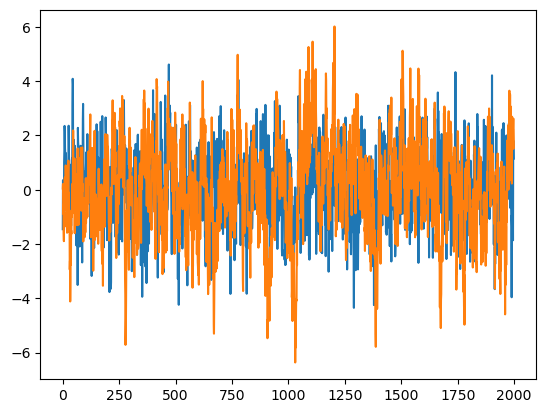

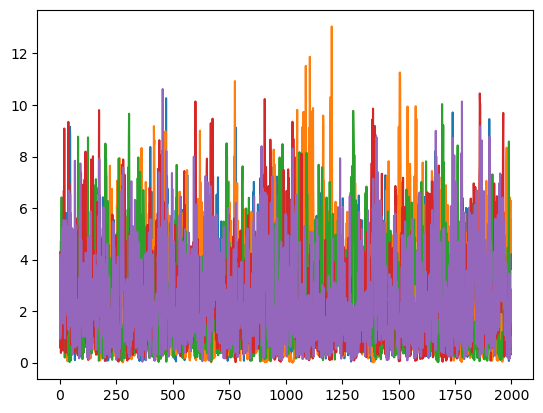

24.190854597791247


In [9]:
# Simulate some data
torch.manual_seed(0)
np.random.seed(0)
N = 100
x_dim = 5

# sqrt m  division in matrix C 

# A = np.array([[0.9, 0.4], [-0.2, 0.8]])
# s = np.array([0.8, 0.99]).reshape(1, -1)
# u, _ = np.linalg.qr(np.random.randn(s.shape[1], s.shape[1]))
# A = u @ np.diag(s.squeeze()) @ u.T
eigs = np.array([-0.6, 0.2, 0.6, 0.8, 0.9])
A = np.diag(eigs)
u, _ = np.linalg.qr(np.random.randn(x_dim, x_dim))
A = u @ A @ u.T
print(A)

# B = np.array([[0.1, 0.0], [0.0, 0.1]])
B = 1 * np.eye(x_dim)
W = np.eye(x_dim)
# W = np.array([[1, 0], [0, 1]])
# C = np.random.randn(N, x_dim)

# Have C to be multiple identity matrices
C = np.vstack([np.eye(x_dim)] * (N//x_dim)) # Could also use random weights with std sqrt(m)

sigma_x = 0.01

# mu0 = np.array([0., 0.])
# Sigma0 = np.array([[.010, 0.0], [0.0, .010]])
mu0 = np.zeros(x_dim)
Sigma0 = 1 * np.eye(x_dim)
print(mu0.shape, Sigma0.shape)

ntrials = 1
# v0 = np.random.multivariate_normal(mu0, Sigma0)
v0 = mu0 + (np.linalg.cholesky(Sigma0) @ np.random.randn(ntrials,x_dim, 1)).squeeze(-1)

T = 2000
v = np.zeros((ntrials,x_dim,T))
x = np.zeros((ntrials,x_dim,T))
x_noise_free = np.zeros((ntrials,x_dim,T))
v[:,:, 0] = v0
x_noise_free[:,:, 0] = (W @ v0[..., None]).squeeze(-1)
x[:,:, 0] = (W @ v0[..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim,)
for t in range(1, T):
    v[..., t] = (A @ v[..., t-1][..., None]).squeeze(-1) + (B @ np.random.randn(ntrials, x_dim,1)).squeeze(-1)
    x_noise_free[..., t] = (W @ v[..., t][..., None]).squeeze(-1)
    x[..., t] = (W @ v[..., t][..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim)

stop = -1
plt.plot(v[-1,0,:stop])
plt.plot(v[-1,1,:stop])
plt.show()

_d = 0.5
F = C[None, ...] @ x + _d
# plt.plot(F[0,0,:stop])
# plt.plot(F[0,1,:stop])

# link = np.exp
link = lambda x: 20 * np.log(1 + np.exp(x))
dt = .1
for i in range(5):
    plt.plot(link(F[0,i,:stop])*dt)
plt.show()

# Average firing rate
print(np.mean(link(F)))


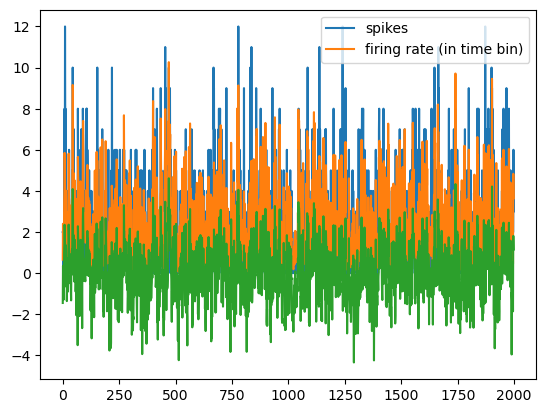

In [10]:
# link_fn = torch.exp
# link = lambda x: np.exp(x)
link_fn = lambda x: 20 * torch.nn.functional.softplus(x)
link = lambda x: 20 * np.log(1 + np.exp(x))
lik = Poisson_noise()
Y = np.random.poisson(link(F)*dt)

train_len = 1000
Y_train = Y[..., :train_len]
v_train = v[..., :train_len]
Y_test = Y[..., train_len:]
v_test = v[..., train_len:]


# sigma = 0.1
# Y = np.random.randn(*F.shape) * sigma + F
# lik = Gaussian_noise(sigma)
# link_fn = lambda x: x

# # Sigmoid link function
# link = lambda x: 1 / (1 + np.exp(-x))
# Y = np.random.negative_binomial(link(F), 0.5)
# lik = Negative_binomial_noise(Tensor(Y))
# link_fn = lambda x:x

plt.plot(Y[0,0,:stop], label='spikes')
# plt.plot(Y[0,1,:stop])
plt.plot(link(F[0,0,:stop])*dt, label='firing rate (in time bin)')
plt.plot(x_noise_free[0,0,:stop])
plt.legend()
plt.show()

# model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, fixed_d=False, d=_d)
# train_params = {'batch_size': None, 'n_mc': 500, 'step_size': 100, 'lrate': 5e-3, 'max_steps': 1001, 'gamma': 0.85}
# np.random.seed(0)
# torch.manual_seed(0)
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

# Fixed generative model
model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, 
            A=Tensor(A[None, ...]).to(device), B=Tensor(B[None, ...]).to(device), W=Tensor(W[None,...]).to(device), C=Tensor(C[None, ...]).to(device),
            mu0=Tensor(mu0[None, ...]).to(device), Sigma0_half=Tensor(np.linalg.cholesky(Sigma0)[None, ...]).to(device),
            sigma_x=Tensor([sigma_x]).to(device), d=_d)

In [11]:
for name, prm in model.named_parameters():
    if name in ['C', 'W']:
        continue
    print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')


# print(C @ W )
# print(model.C @ model.W)
print((C@W - (model.C @ model.W).detach().cpu().numpy()))
# print(C @ W)
print(model.Sigma0)

Name: A - Shape: torch.Size([1, 5, 5]) - Parameter: Parameter containing:
tensor([[[ 0.2782,  0.2092, -0.1578, -0.1160,  0.5027],
         [ 0.2092,  0.6254, -0.0744, -0.1590, -0.3495],
         [-0.1578, -0.0744,  0.5679, -0.2399, -0.0460],
         [-0.1160, -0.1590, -0.2399,  0.5348,  0.1155],
         [ 0.5027, -0.3495, -0.0460,  0.1155, -0.1064]]], device='cuda:0',
       requires_grad=True)
Name: B - Shape: torch.Size([1, 5, 5]) - Parameter: Parameter containing:
tensor([[[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]]], device='cuda:0', requires_grad=True)
Name: log_sigma_x - Shape: torch.Size([1]) - Parameter: Parameter containing:
tensor([-4.6052], device='cuda:0', requires_grad=True)
Name: mu0 - Shape: torch.Size([1, 5]) - Parameter: Parameter containing:
tensor([[0., 0., 0., 0., 0.]], device='cuda:0', requires_grad=True)
Name: Sigma0_half - Shape: torch.Size([1, 5, 5]) - Paramet

torch.Size([1, 1, 5, 1000])


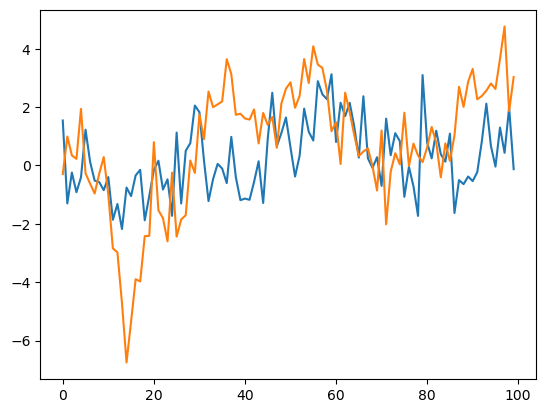

In [6]:
model.freeze_params()
z_samps = model.sample_z(1)
print(z_samps.shape)
stop = 100
for i in range(len(z_samps)):
    plt.plot(z_samps[i,0,0, :stop].detach().cpu().numpy())
    plt.plot(z_samps[i,0,1, :stop].detach().cpu().numpy())
    plt.show()

In [4]:
# Load saved neural network
state_dict = torch.load('my_sequential_model.pth')

In [14]:

model.freeze_params()
print(model.x_dim)

class MyRNNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
        self.fc = torch.nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = MyRNNModel(model.N, 100, model.x_dim)

# Substituting the true parameters
neural_net = torch.nn.Sequential(
                torch.nn.Linear(model.N, 100),
                torch.nn.ReLU(),
                torch.nn.Linear(100, 100),
                torch.nn.ReLU(),
                torch.nn.Linear(100, 100),
                torch.nn.ReLU(),
                # torch.nn.Linear(100, 100),
                # torch.nn.ReLU(),
                torch.nn.Linear(100, model.x_dim)
            )
# neural_net.load_state_dict(state_dict)
# rec_model = RecognitionModel(model, neural_net=neural_net)

rec_model = RecognitionModel(model, rnn=True, neural_net=neural_net)
train_params = {'batch_size': None, 'step_size': 10, 'lrate': 5e-3, 'max_steps': 101, 'n_mc_x': 50, 'n_mc_z': 50, 'batch_mc_z': 25}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

5
step 0 LL -4.2400909375
step 1 LL -3.7631715625
step 2 LL -3.0721490625
step 3 LL -3.49148125
step 4 LL -2.7818840625
step 5 LL -2.7549815625
step 6 LL -2.865494375
step 7 LL -2.89255703125


KeyboardInterrupt: 

torch.Size([1, 100, 1000])


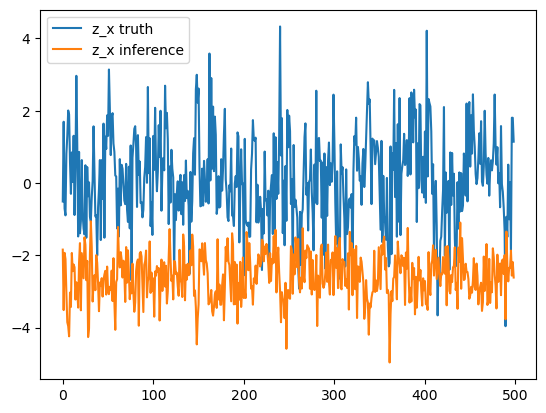

-1.3133449417336123
-4.117607001801779
(1, 5, 2000)


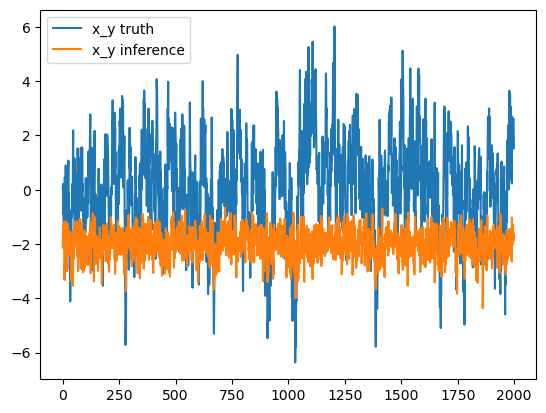

-4.117877274585835 x_x
-1.313494432798449 x_y


IndexError: index 1000 is out of bounds for dimension 0 with size 1000

In [15]:
print(rec_model.gen_model.Y.shape)
z = rec_model.test_z(Tensor(Y).to(device))
z = z.detach().cpu().numpy()

start = 1500
stop = -1
plt.plot(v[0,0,start:stop], label = 'z_x truth')
# plt.plot(v[0,1,:100], label = 'z_y truth')
plt.plot(z[0,0,start:stop], label = 'z_x inference')
# plt.plot(z[0,1,:100], label = 'z_y inference')
plt.legend()
plt.show()

# for i in range(5):
#     plt.plot(z[0,i,:stop], label = 'z_x inference')
# plt.show()
# for i in range(5):
#     plt.plot(v[0,i,:stop], label = 'z_x truth')   
#     # plt.legend()
# plt.show()

# print R^2 for x and y decoding using sklearn
print(r2_score(v[0,1,:], z[0,1,:]))
print(r2_score(v[0,0,:], z[0,0,:]))


x_tilde = rec_model.get_x_tilde(Tensor(Y).to(device)).detach().cpu().numpy()
print(x_tilde.shape)
stop = -1
# plt.plot(x_noise_free[0,0,:stop], label = 'x_x truth')
# plt.plot(x_tilde[0,0,:stop], label = 'x_x inference')
plt.plot(x_noise_free[0,1,:stop], label = 'x_y truth')
plt.plot(x_tilde[0,1,:stop], label = 'x_y inference')
plt.legend()
plt.show()
# print R^2 for x_tilde
print(r2_score(x_noise_free[0,0,:], x_tilde[0,0,:]), 'x_x')
print(r2_score(x_noise_free[0,1,:], x_tilde[0,1,:]), 'x_y')
# print(r2_score(x_noise_free, x_tilde), 'x_all')

_, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
mus_smooth = mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0)
print(mus_smooth.shape)
stop = 100
plt.plot(v[0,0,:stop], label = 'z_x truth')
plt.plot(mus_smooth[0, 0,:stop], label = 'z_x inference')
plt.plot(v[0,1,:stop], label = 'z_y truth')
plt.plot(mus_smooth[0, 1,:stop], label = 'z_y inference')
plt.legend()
plt.show()

# print R^2 for x and y smoothing using sklearn
print(r2_score(v[0,1,:], mus_smooth[0, 1,:]))
print(r2_score(v[0,0,:], mus_smooth[0, 0,:]))


In [ ]:
# Checking what sampled posteriors look like
matheron_pert = rec_model.sample_matheron_pert(100)
print(matheron_pert.shape)
x_hat = Tensor(x[None, ...]).to(device) - matheron_pert[..., :x_tilde.shape[-1]]
print(x_hat.shape)
_, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , _mus_smooth, _ = rec_model.kalman_means(x_hat, Ks, Cs) # (batch_size, n_mc_z, ntrials, b)
_mus_smooth = _mus_smooth.permute(1,2,3,0).squeeze().detach().cpu().numpy()
print(_mus_smooth.shape)


# # Find the prior mean
# z_samps = model.sample_z(10000)
# z_samps = z_samps.squeeze().detach().cpu().numpy()
# print(z_samps.shape)

torch.Size([100, 1, 2, 5000])
torch.Size([100, 1, 2, 5000])
(100, 2, 5000)


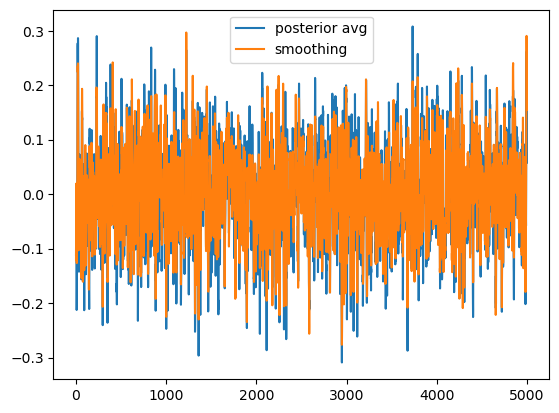

0.7522298766551174
0.86521357134445


In [ ]:
# stop = 100
# for i in range(len(_mus_smooth)):
#     plt.plot(_mus_smooth[i,0,:stop])
#     # plt.plot(_mus_smooth[i,0,1,:stop])
#     # plt.show()
# plt.show()

stop = -1
posterior_avg = _mus_smooth.mean(0)
prior_avg = z_samps.mean(0)
plt.plot(posterior_avg[0,:stop], label = 'posterior avg')
plt.plot(mus_smooth[0,:stop], label = 'smoothing')
# plt.plot(prior_avg[0,:stop], label = 'prior avg')
# plt.plot(z_samps[0,0,:stop], label = 'prior sample')
plt.legend()
plt.show()
# print R^2 between posterior mean and smoothing
print(r2_score(mus_smooth[0,:], posterior_avg[0,:]))
print(r2_score(mus_smooth[1,:], posterior_avg[1,:]))

In [ ]:
# # Natural parameters for p(v_t|v_{t-1})
# mus = self.A @ v[... , :-1] # (ntrials, b, T-1)
# # print(mu.shape, self.Q.shape)
# second_big = torch.zeros(ntrials).to(device)
# for t in range(T-1): # TODO, can we vectorize this?
#     dist = MultivariateNormal(mus[..., t], self.Q)
#     second_big += dist.log_prob(v[..., t+1])

# # # Replace the for loop with this code
# # dist = MultivariateNormal(mus, self.Q[..., None])
# # second_big = dist.log_prob(v[..., 1:]).sum(dim=-1)

mus = torch.zeros(4, 2, 9)
Q = torch.eye(2)[None, ...]
# Q = Q.expand(4, -1, -1)
v = torch.zeros(4, 2, 10)
print(mus.shape, Q.shape)

T = 10
second_big = torch.zeros(4)
for t in range(T-1): # TODO, can we vectorize this?
    print(mus[..., t].shape, Q.shape)
    dist = MultivariateNormal(mus[..., t], Q)
    second_big += dist.log_prob(v[..., t+1])

print(second_big.shape, second_big)

# Replace the for loop with this code
# dist = MultivariateNormal(mus, Q[..., None].expand(-1, -1, -1, mus.shape[-1]))
# second_big = dist.log_prob(v[..., 1:]).sum(dim=-1)
# print(second_big.shape, second_big)
# mus = mus.transpose(-1,-2)
# print(mus.shape)
mus = mus.transpose(-1,-2)
# Q = Q[:, None, ...].expand(-1, mus.shape[1], -1, -1)
Q = Q[:, None, ...]
print(Q.shape, mus.shape)
dist = MultivariateNormal(mus, Q)
v = v[..., 1:].transpose(-1,-2)
print(v.shape)
second_big = dist.log_prob(v).sum(dim=-1)
print(second_big.shape, second_big)


torch.Size([4, 2, 9]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4]) tensor([-16.5409, -16.5409, -16.5409, -16.5409])
torch.Size([1, 1, 2, 2]) torch.Size([4, 9, 2])
torch.Size([4, 9, 2])
torch.Size([4]) tensor([-16.5409, -16.5409, -16.5409, -16.5409])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline

torch.set_default_dtype(torch.float64)

In [15]:
# Train 4G10 model
# z = np.load('4G10_z.npy')
# z = z.transpose(1,0, 2)
z = np.load('4G10_z_ayush.npy')
print(z.shape)
z = torch.Tensor(z)

Y_train = np.load('neural_train.npy')
Y_train = Y_train.transpose(1,0,2)
Y_train = torch.Tensor(Y_train)
print(Y_train.shape)

Y_test = np.load('neural_test.npy')
Y_test = Y_test.transpose(1,0,2)
Y_test = torch.Tensor(Y_test)
print(Y_test.shape)



(400, 10, 16)
torch.Size([400, 162, 16])
torch.Size([100, 162, 16])


In [16]:


min_firing_rate = 0.1 # Hz
T_trial = 16 * 50 /1000 # seconds
print(Y_train.mean(dim=(0, 2))/T_trial)
_Y_train = Y_train[:, Y_train.mean(dim=(0, 2))/T_trial > min_firing_rate, :]
_Y_test = Y_test[:, Y_train.mean(dim=(0, 2))/T_trial > min_firing_rate, :]
print(_Y_train.shape)
print(_Y_test.shape)

tensor([0.1023, 0.1711, 0.5150, 0.1553, 0.3377, 0.0291, 0.2096, 0.8529, 0.5342,
        0.4148, 0.1994, 0.0303, 0.0791, 1.2572, 0.0910, 0.8965, 0.3662, 0.0525,
        0.0348, 0.2645, 0.1555, 0.7842, 1.3041, 0.3535, 0.4150, 0.2262, 0.3520,
        0.5375, 0.2432, 0.4504, 0.0123, 0.2645, 0.1229, 0.1521, 0.3779, 0.2332,
        0.0055, 0.7191, 0.0266, 0.1424, 0.2758, 0.3250, 0.1600, 0.1961, 0.2400,
        0.5227, 0.1855, 0.1615, 0.1412, 0.4430, 0.3865, 0.3096, 0.4412, 0.2895,
        0.0170, 0.4852, 0.2123, 0.5924, 0.0334, 0.1574, 0.1877, 0.2029, 0.0656,
        0.3236, 0.4859, 0.3006, 0.6943, 0.3084, 0.0090, 0.4633, 0.0941, 0.2191,
        0.2338, 0.4986, 0.1295, 0.9152, 0.3830, 0.1848, 0.0555, 0.3355, 0.0492,
        0.0262, 0.4537, 0.0551, 0.1014, 0.2844, 0.3187, 0.0793, 0.4197, 0.3180,
        0.0650, 0.5121, 0.7711, 0.1262, 0.8074, 0.2336, 0.3979, 0.2195, 0.1879,
        0.3779, 0.1301, 0.2045, 0.0820, 0.2865, 0.6920, 0.2469, 0.0687, 0.3035,
        0.2936, 0.3449, 0.1834, 0.0836, 

In [5]:
A = np.load('A.npy')
A = torch.Tensor(A[None, ...]).to(device)
Q = np.load('Q.npy')
B = np.linalg.cholesky(Q)
B = torch.Tensor(B[None, ...]).to(device)
mu0 = np.load('mu0.npy')
mu0 = torch.Tensor(mu0[None, ...]).to(device)
Sigma0 = np.load('Sigma0.npy')
Sigma0_half = np.linalg.cholesky(Sigma0)
Sigma0_half = torch.Tensor(Sigma0_half[None, ...]).to(device)

np.random.seed(0)
torch.manual_seed(0)

link_fn = torch.functional.F.softplus
# link_fn = torch.exp
lik = Poisson_noise()

# link_fn = lambda x: x
# lik = Gaussian_noise(0.1)

# link_fn = lambda x: x
# lik = Negative_binomial_noise(Tensor(Y_train))


# # model = LDS(z, _Y_train, lik, link_fn=link_fn)
model = LDS(z, _Y_train, lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True, fixed_d=False)
print(model.N, model.T, model.x_dim, model.b, model.ntrials)
train_params = {'batch_size': None, 'n_mc': 100, 'lrate': 7.5e-2, 'max_steps': 1001, 'step_size': 500}
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

125 16 10 10 400
step 0 LL -0.009382023225019935
step 1 LL -0.006886260614820232
step 2 LL -0.004740390480281119
step 3 LL -0.003815261261847628
step 4 LL -0.003169754231807892
step 5 LL -0.0028920661472351195
step 6 LL -0.0027967584888967095
step 7 LL -0.0027406136158028248
step 8 LL -0.0025453537346152156
step 9 LL -0.002305510641649207
step 10 LL -0.0022088695689778566
step 11 LL -0.002147630947584066
step 12 LL -0.00205156772697688
step 13 LL -0.0019809326174191266
step 14 LL -0.0019457977784198928
step 15 LL -0.0019315376526060693
step 16 LL -0.0019213031198467715
step 17 LL -0.0018695487124584889
step 18 LL -0.0018333456220092689
step 19 LL -0.0018456759877799643
step 20 LL -0.0018299014673833485
step 21 LL -0.0017975552281620413
step 22 LL -0.0017741682042610313
step 23 LL -0.001759972028911214
step 24 LL -0.0017559357029852832
step 25 LL -0.0017631143455817122
step 26 LL -0.0017523748408484123
step 27 LL -0.0017414111964679073
step 28 LL -0.0017259565643351765
step 29 LL -0.001

KeyboardInterrupt: 

In [6]:
model.freeze_params()

# for name, prm in model.named_parameters():
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')

# print(Q - (B @ B.transpose(-1,-2)).detach().cpu().numpy())
print('d', model.d)
print('sigma_x', model.sigma_x)
print('Q', torch.diag(model.Q[0]))
print((model.C @ model.W).sum(axis=-1))

# print(torch.linalg.det(model.Sigma0))
# # min eigenvalue of Sigma0
# min_abs_eigenvalue = torch.abs(torch.linalg.eigvals(model.Sigma0)).min()
# print(min_abs_eigenvalue)

# # print(model.lik.total_count)

# print(model.Q)

d Parameter containing:
tensor(-1.4889, device='cuda:0')
sigma_x tensor(1.1541, device='cuda:0')
Q tensor([ 2.6188,  0.8298,  1.7076,  9.1700,  1.9010,  2.0378,  5.9992,  1.9473,
        16.5578,  5.1940], device='cuda:0')
tensor([[ 0.4027,  0.5118, -1.0687, -0.0237,  1.3021,  0.5599,  1.3067, -0.2103,
          0.0601,  0.1947,  1.5270, -1.0215, -0.7321,  0.3288,  0.0315,  0.9039,
          1.2543, -1.4082, -0.9821, -1.2730, -0.3261,  0.8971, -0.8084,  0.2896,
          0.2286, -0.2009, -0.3699, -0.1268,  0.2020,  1.6042, -0.1446,  0.9142,
          0.8704, -0.0855, -0.1124,  0.0561, -0.5063,  0.0279,  0.0432,  0.0677,
          0.7363,  0.3525, -0.0644,  0.6861,  0.2258,  0.3522,  0.2063,  0.3360,
         -0.0359, -0.4425, -0.1362,  1.0532,  0.7887,  0.7792,  0.9898, -0.7803,
          0.8664, -0.2610, -0.3418,  0.6560,  0.2395,  1.1949, -0.0804, -0.1101,
          1.2836,  0.3709,  0.0340, -0.3537,  0.6395, -0.0989,  0.4585,  0.9580,
          0.6388,  0.1568,  0.9827, -0.4878, -0.

torch.Size([3, 400, 10, 16])


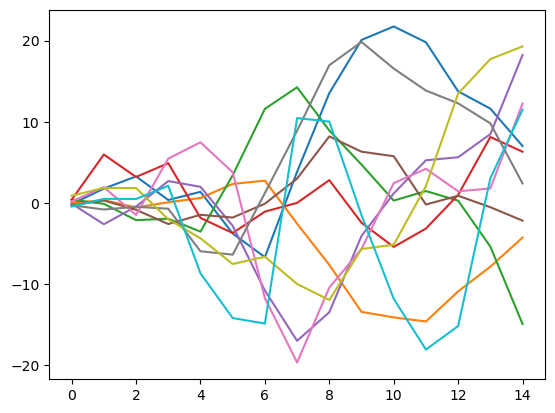

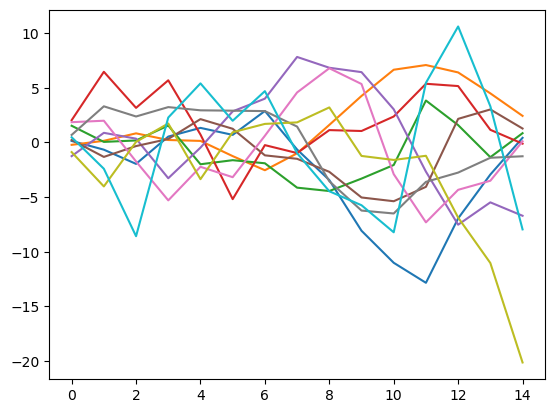

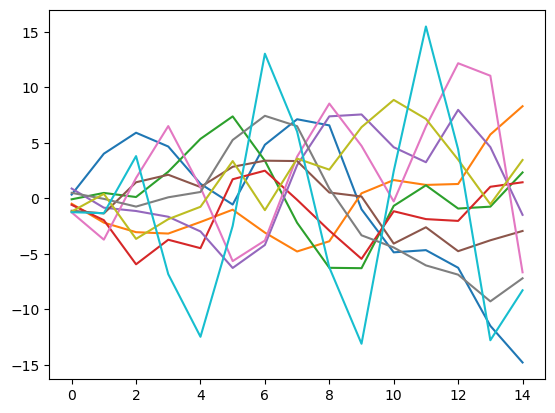

In [10]:
z_samps = model.sample_z(3)
print(z_samps.shape)
stop = -1
for i in range(len(z_samps)):
    for j in range(10):
        plt.plot(z_samps[i,0,j, :stop].detach().cpu().numpy())
    plt.show()

In [7]:
model.freeze_params()
rec_model = RecognitionModel(model, rnn=True)
train_params = {'batch_size': 100, 'step_size': 10, 'lrate': 5e-3, 'max_steps': 1001, 'n_mc_x': 20, 'n_mc_z': 20, 'batch_mc_z': 20}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

step 0 LL -0.1758148655997222
step 1 LL -0.17502421162374768
step 2 LL -0.17435376367495628
step 3 LL -0.1735583281564309
step 4 LL -0.1730114368084182
step 5 LL -0.17291485357202407
step 6 LL -0.1726888484740408
step 7 LL -0.17241527164606843
step 8 LL -0.17221850466376934
step 9 LL -0.17207558404039727
step 10 LL -0.17198675649354175
step 11 LL -0.17186392413773927
step 12 LL -0.17179126281537038
step 13 LL -0.17167186190333508
step 14 LL -0.1716114559104369
step 15 LL -0.1715630510092122
step 16 LL -0.17148943169575478
step 17 LL -0.17145473697267433
step 18 LL -0.17132907265163275
step 19 LL -0.17133065862551317
step 20 LL -0.17127878169928967
step 21 LL -0.17122784440245253
step 22 LL -0.17121979423502903
step 23 LL -0.17125375015335248
step 24 LL -0.17119071275717762
step 25 LL -0.1711788795563574
step 26 LL -0.17117014422494015
step 27 LL -0.17110967553903791
step 28 LL -0.17114435006626483
step 29 LL -0.17107276741175775
step 30 LL -0.17108254235077847
step 31 LL -0.17106046256

KeyboardInterrupt: 

(400, 10, 16)
(2, 10)
(400, 2, 16)


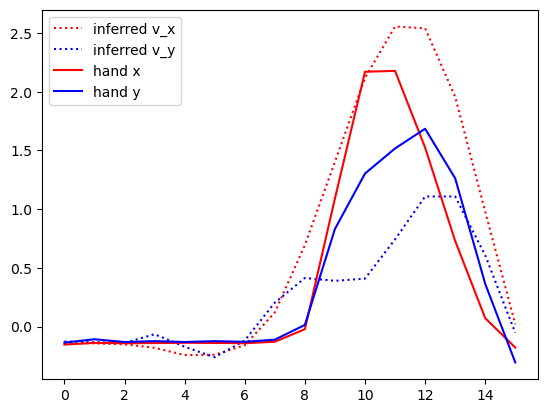

0.5537841611296963
(2, 100, 16)
0.6958092595223653
0.1793384274296373


In [42]:
z = rec_model.test_z(rec_model.gen_model.Y)
# z = rec_model.test_z(Tensor(_Y_test).to(device))
z = z.detach().cpu().numpy()
print(z.shape)

C = np.load('C.npy')
print(C.shape)
v = (C[None, ...] @ z)
print(v.shape)

hand_train = np.load('hand_train.npy')
hand_train = hand_train.transpose(1,0,2)

for trial in range(1):
    plt.plot(v[trial,0,:], label = 'inferred v_x', color='red', linestyle='dotted')
    plt.plot(v[trial,1,:], label = 'inferred v_y', color='blue', linestyle='dotted')
    plt.plot(hand_train[trial,0,:], label = 'hand x', color='red')
    plt.plot(hand_train[trial,1,:], label = 'hand y', color='blue')
    plt.legend()
    plt.show()

trials = 100
v_dim = 2
r2_scores = np.zeros((v_dim, trials))
for trial in range(trials):
    for i in range(v_dim):
        r2_scores[i, trial] = r2_score(hand_train[trial,i,:], v[trial,i,:])

# Only consider where r_2 > 0
print(r2_scores[r2_scores > 0].mean())
# print(r2_scores.mean(axis=1))
# # print(r2_scores)
# print(r2_scores.argsort(axis=1))

# np.save('inferred_z.npy', v.transpose(1,0,2))

cw_v = np.load('KF.npy')
z_test = rec_model.test_z(Tensor(_Y_test).to(device))
z_test = z_test.detach().cpu().numpy()
v_test = (C[None, ...] @ z_test).transpose(1,0,2)
print(v_test.shape)

r2_scores = np.zeros((v_dim, trials))
for trial in range(v_test.shape[1]):
    for i in range(v_dim):
        r2_scores[i, trial] = r2_score(cw_v[i,trial,:], v_test[i,trial,:])
print(r2_scores[r2_scores > 0].mean())
